In [1]:

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
 
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial
 
AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')

2024-06-14 12:43:48.213465: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 12:43:48.260216: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 12:43:48.260841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 12:43:49.225298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

images = glob('data/*/*.jpg')
len(images)

418

In [3]:
images = [path.replace('\\', '/') for path in images]
df = pd.DataFrame({'filepath': images})
df['label'] = df['filepath'].str.split('/', expand=True)[1]
df.head()

,filepath,label
0,data/benign/39.jpg,benign
1,data/benign/42.jpg,benign
2,data/benign/12.jpg,benign
3,data/benign/25.jpg,benign
4,data/benign/35.jpg,benign


In [4]:
df['label'] = df['label'].str.replace('ISIC-', '')
#df.head(50)

random_sample = df.sample(n=25)
print(random_sample)

                              filepath      label
50   data/ISIC-benign/ISIC_7579869.jpg     benign
150  data/ISIC-benign/ISIC_6038442.jpg     benign
290              data/malignant/82.jpg  malignant
415             data/malignant/168.jpg  malignant
248             data/malignant/204.jpg  malignant
2                   data/benign/12.jpg     benign
149  data/ISIC-benign/ISIC_0784936.jpg     benign
268             data/malignant/124.jpg  malignant
370              data/malignant/14.jpg  malignant
400               data/malignant/2.jpg  malignant
294             data/malignant/172.jpg  malignant
301             data/malignant/131.jpg  malignant
20                  data/benign/26.jpg     benign
81   data/ISIC-benign/ISIC_5985738.jpg     benign
89   data/ISIC-benign/ISIC_5959220.jpg     benign
225             data/malignant/294.jpg  malignant
179              data/malignant/67.jpg  malignant
23                   data/benign/3.jpg     benign
296             data/malignant/106.jpg  malignant


In [5]:

df['label_bin'] = np.where(df['label'].values == 'malignant', 1, 0)
df.head()

,filepath,label,label_bin
0,data/benign/39.jpg,benign,0
1,data/benign/42.jpg,benign,0
2,data/benign/12.jpg,benign,0
3,data/benign/25.jpg,benign,0
4,data/benign/35.jpg,benign,0


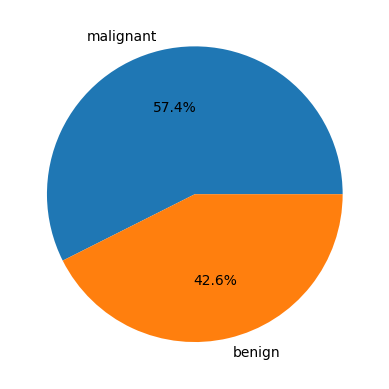

In [6]:

x = df['label'].value_counts()
plt.pie(x.values,
        labels=x.index,
        autopct='%1.1f%%')
plt.show()


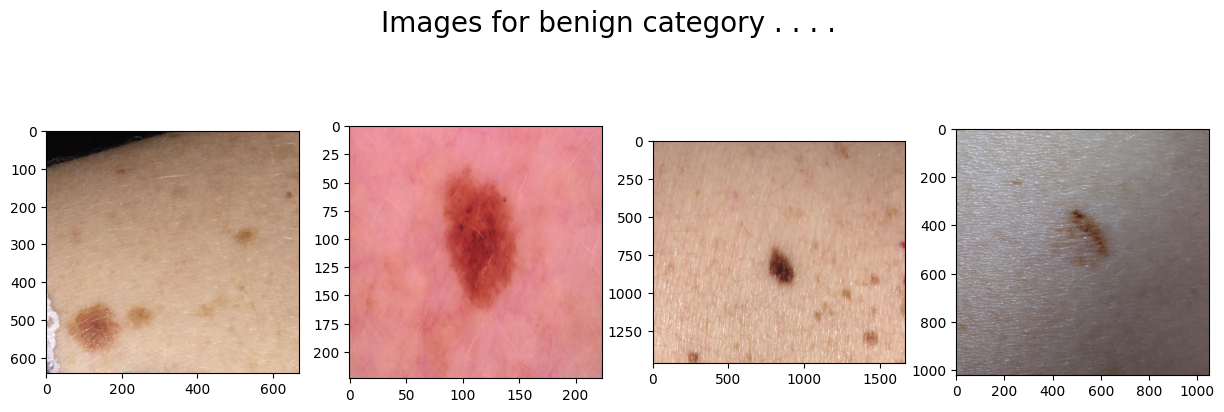

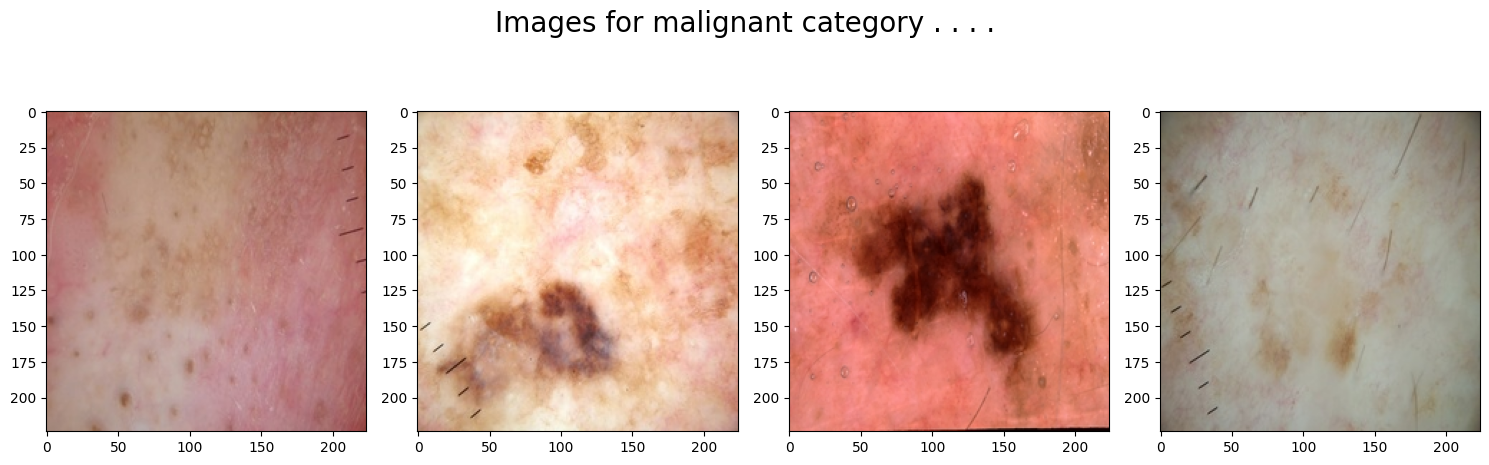

In [7]:

for cat in df['label'].unique():
    temp = df[df['label'] == cat]
 
    index_list = temp.index
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    for i in range(4):
        index = np.random.randint(0, len(index_list))
        index = index_list[index]
        data = df.iloc[index]
 
        image_path = data[0]
 
        img = np.array(Image.open(image_path))
        ax[i].imshow(img)
plt.tight_layout()
plt.show()


In [8]:

features = df['filepath']
target = df['label_bin']
 
X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.15,
                                      random_state=10)
 
X_train.shape, X_val.shape, Y_train.shape , Y_val.shape


((355,), (63,), (355,), (63,))

In [26]:
tdy = list(Y_train)
tdx = list(X_train)

len(set(tdx) - set(tdy))


355

In [61]:

def decode_image(filepath, label):
 
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0

    print('label:', label)
    if label == 'benign':
        Label = 0
    else:
        Label = 1
 
    return img, Label




In [ ]:
# def decode_image(filepath, label=None):
 
#     img = keras.utils.load_img(filepath, target_size=(224, 224))
#     x = keras.utils.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     x = preprocess_input(x)


#     print(x) 
#     return x

In [62]:

train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)
 
val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)


print(train_ds)

label: Tensor("args_1:0", shape=(), dtype=int64)


TypeError: in user code:

    File "/tmp/ipykernel_46294/2444303342.py", line 9, in decode_image  *
        if label == 'benign':

    TypeError: Expected int64 passed to parameter 'y' of op 'Equal', got 'benign' of type 'str' instead. Error: Expected int64, but got benign of type 'str'.


In [42]:


from tensorflow.keras.applications.efficientnet import EfficientNetB7
 
pre_trained_model = EfficientNetB7(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)
 
for layer in pre_trained_model.layers:
    layer.trainable = False


In [43]:

from tensorflow.keras import Model
 
inputs = layers.Input(shape=(224, 224, 3))
x = layers.Flatten()(inputs)
 
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
 
model = Model(inputs, outputs)


In [44]:

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['AUC']
)


In [47]:

history = model.fit(train_ds,
                    #validation_data=val_ds,
                    epochs=5,
                    batch_size=1,
                    verbose=1)


Epoch 1/5


ValueError: in user code:

    File "/home/funda/Projects/ML-projects/winefore/ML-env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/home/funda/Projects/ML-projects/winefore/ML-env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/funda/Projects/ML-projects/winefore/ML-env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/home/funda/Projects/ML-projects/winefore/ML-env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1082, in train_step
        self._validate_target_and_loss(y, loss)
    File "/home/funda/Projects/ML-projects/winefore/ML-env/lib/python3.8/site-packages/keras/src/engine/training.py", line 1036, in _validate_target_and_loss
        raise ValueError(

    ValueError: Target data is missing. Your model was compiled with loss=<keras.src.losses.BinaryCrossentropy object at 0x7f24295433d0>, and therefore expects target data to be provided in `fit()`.


In [ ]:

hist_df = pd.DataFrame(history.history)
hist_df.head()
